# Project: Predictive Modeling in the Process Industry
- **Motivation**: Apply machine learning models and statistical methods in a project relevant for the process industry. Use knowledge gained by textbooks about *Data Science* (e.g. [Hands-on Machine Learning](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), [Python Data Science Handbook](https://www.oreilly.com/library/view/python-data-science/9781491912126/) and [Practical Statistics for Data Scientists](https://www.oreilly.com/library/view/practical-statistics-for/9781492072935/)).
- **Problem**: Predict the power output of an combined cycle power plant (CCPP) using regression models
- **Data**: CCPP [data](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant) available online for free (it is probaly [this](https://en.wikipedia.org/wiki/Tekirda%C4%9F_gas_power_plant_A) plant and there exists a [publication](https://www.sciencedirect.com/science/article/abs/pii/S0142061514000908?via%3Dihub) using this data set)

<div class="alert alert-block alert-info">
<b>Approach:</b> 
<ol>
<li>Exploratory data analysis 
<li>Regression for predictive modeling 
<li>Analysis of model and residuals
<ol>
</div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import sklearn

# Plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', titlesize=18)
mpl.rc('legend', fontsize=14)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

np.random.RandomState(seed=42)

RandomState(MT19937) at 0x205F65CC940

# 1. Exploratory data analysis
Summarize the main characteristics of the data set.

## Import data

In [2]:
data = pd.read_excel('./CCPP_dataset/ccpp_data.xlsx')
data.head(3)

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56


## Variables and units

| Symbol | Name   | Unit |
|--------|--------|------|
| AT | Ambient temperature | °C |
| V  | Exhaust vacuum | cmHg (~1333 Pa) |
| AP | Ambient pressure | mbar |
| RH | Relative humidity | % |
| PE | Net hourly electrical energy output | MW |

## Inspect data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [4]:
data.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


Check for nan values:

In [5]:
data.isnull().any()

AT    False
V     False
AP    False
RH    False
PE    False
dtype: bool

<div class="alert alert-block alert-success">
<li>No nan values
<li>No negative values
<li>Values are within reasonable ranges (e.g. the max ambient temperature AT is 37.11°C); values outside of reasonable ranges indicate e.g. bad sensor measurements
<li>The mean ambient pressure AP is ~1.01326 bar, which approximately equals the expected standard atmosphere of 1 atm = 1.01325 bar
</div>

Note: In this notebook, the interpretation of plots and other observations are highlighted in green cells.

Drop duplicated values:

In [6]:
data.duplicated().sum() # Number of duplicated rows

41

In [7]:
data.drop_duplicates(inplace=True)
data.shape

(9527, 5)

Convert to float32 (uses less memory):

In [8]:
data.dtypes

AT    float64
V     float64
AP    float64
RH    float64
PE    float64
dtype: object

In [9]:
data = data.astype('float32')
data.dtypes

AT    float32
V     float32
AP    float32
RH    float32
PE    float32
dtype: object

## Explore individual variables 

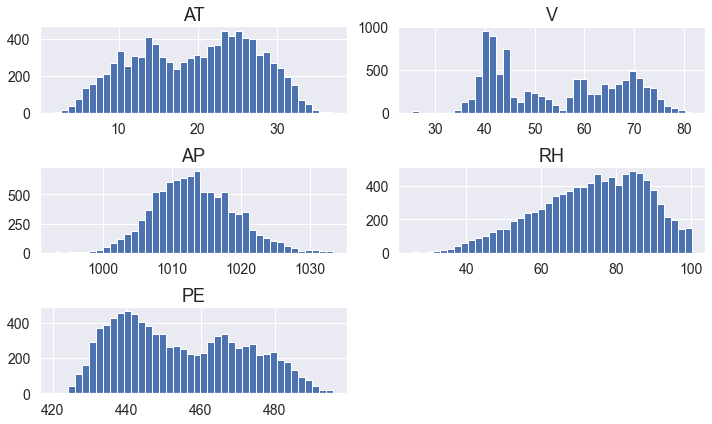

In [10]:
data.hist(bins=40,  figsize=(10,6))
plt.tight_layout()
plt.show()

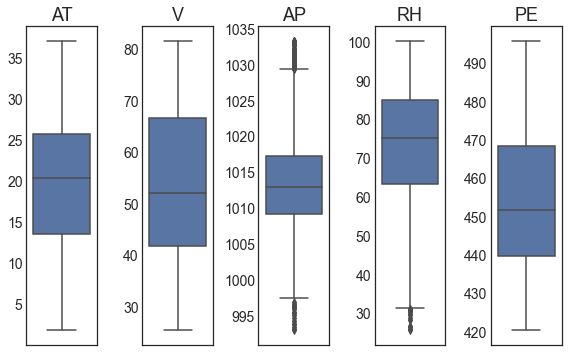

In [11]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,5, figsize=(8,5))
    for i, col in enumerate(data.columns):
        sns.boxplot(data=data[col], ax=ax[i], palette='deep')
        ax[i].set_title(col)
        ax[i].tick_params(labelbottom=False, length=0)  
    plt.tight_layout()
    plt.show()

<div class="alert alert-block alert-success">
<li>All variables have quite compact value ranges (i.e. no wide ranges like 1 to 1e5, which would probably require a log transform in the training stage later)
<li>The most frequent PE value is around 440 MW which is rather at the lower end. The plant therefore often operates with relatively bad power output, compared to what is possible with different operating conditions.
<li>The distributions of AT and PE indicate two possible main operating conditions, e.g. winter and summer or day and night: frequent ambient temperatures AT of around 15°C and 25°C
</div>

## Explore variables pairwise

In [12]:
target   = ['PE']
features = data.columns[:-1].to_list()

### Features vs target
Is the target visibly correlated with the feature variables? 

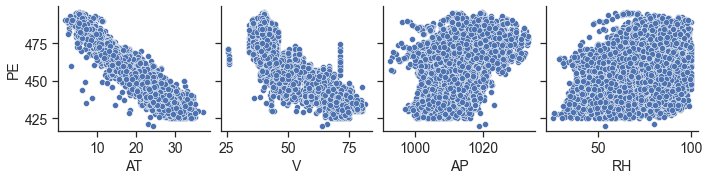

In [13]:
with sns.axes_style('ticks'):
    sns.pairplot(data=data, x_vars=features, y_vars=target, diag_kind=None)

Fit a linear regression model for all feature-target pairs:

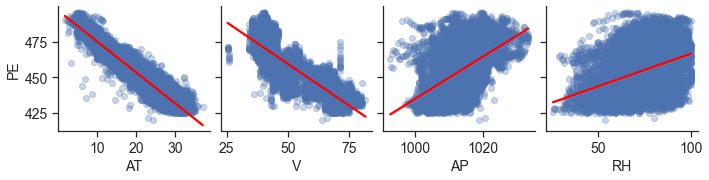

In [14]:
with sns.axes_style('ticks'):
    sns.pairplot(data=data, x_vars=features, y_vars=target, kind='reg', diag_kind=None, 
                 plot_kws={'line_kws':{'color':'red'},'scatter_kws': {'alpha': 0.3}})

<div class="alert alert-block alert-success">
Correlations between features and targets are visible:
<li>PE ~ 1/AT; because the higher the ambient temperature AT, the lower the inlet density, which decreases turbine performance
<li>PE ~ 1/V; because the lower the exhaust vacuum (pressure) of the steam turbine (i.e. higher delta p across the turbine), the higher its performance
<li>The correlation of PE with the other features AP and RH is less linear/strong.
</div>

### Features vs features
Are there correlations between feature variables?

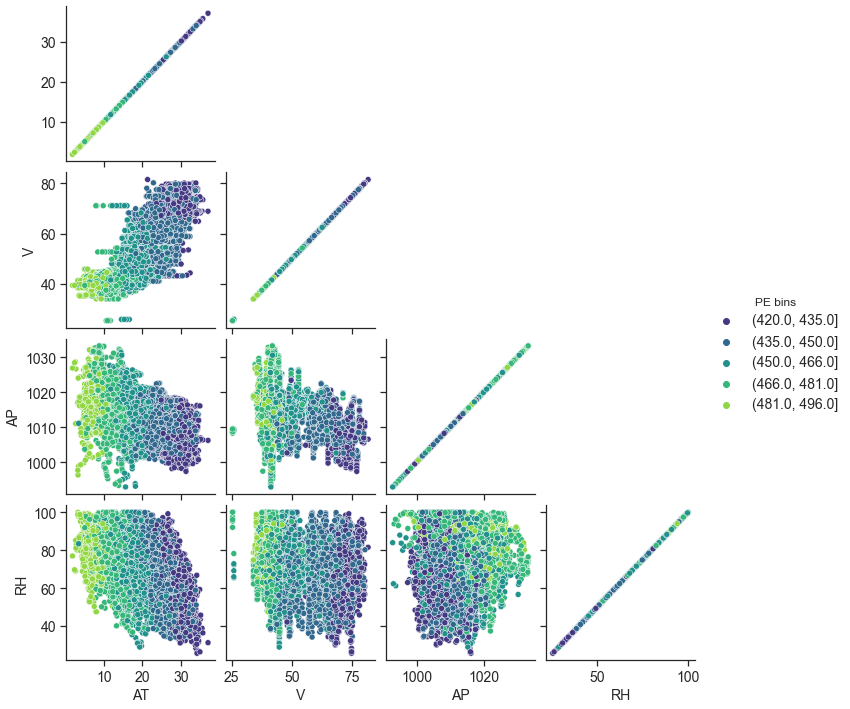

In [15]:
# First create bins of the PE variable. 
# These will be used for the hue (color) argument in the scatter plot.
data_cut = data.copy()
data_cut['PE bins'] = pd.cut(data['PE'], 5, precision=0) 

with sns.axes_style('ticks'):
    sns.pairplot(data=data_cut, x_vars=features, y_vars=features, hue='PE bins', 
                 palette='viridis', diag_kind=None, corner=True)

<div class="alert alert-block alert-success">
Correlations between features variables:
<li>AT ~ V; the higher the ambient temperature, the higher the exhaust vaccum (pressure) of the steam turbine
</div>

### Correlation coefficient

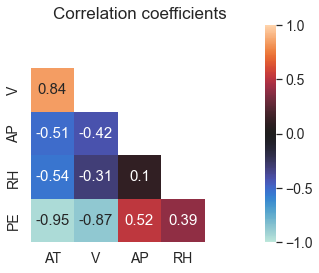

In [16]:
corr = data.corr()

# Heatmap
with sns.axes_style('white'):
    mask = np.triu(np.ones_like(corr))
    plt.figure()
    sns.heatmap(corr, mask=mask, square=True, center=0, vmin=-1, vmax=1, 
                annot=True, annot_kws={'fontsize':15}, 
                xticklabels=features, yticklabels=['','V','AP','RH','PE'])
    plt.title('Correlation coefficients', fontdict={'fontsize':17})
plt.show()

<div class="alert alert-block alert-success">
The correlation coefficients confirm previous observations.
</div>

# 2. Regression for predictive modeling
Prepare the data and evaluate different regression models.

In [17]:
X = data.drop('PE', axis=1) # features
y = data['PE']              # target

## Prepare data 
Split the data into a train and test set, then standardize the data sets.

### Split data

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
print(y_train.shape, y_test.shape)

(7145,) (2382,)


In [19]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### Standardize data
Calculate the mean and the standard deviation only on the train set to avoid data leakage (i.e. sharing of information between train and test sets).

In [20]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train_tr = std.fit_transform(X_train) # get transformed data
X_test_tr  = std.transform(X_test)   

# Create a DataFrame again
X_train_tr = pd.DataFrame(X_train_tr, columns=X_train.columns)
X_test_tr  = pd.DataFrame(X_test_tr,  columns=X_test.columns)

### Inspect the standardized data

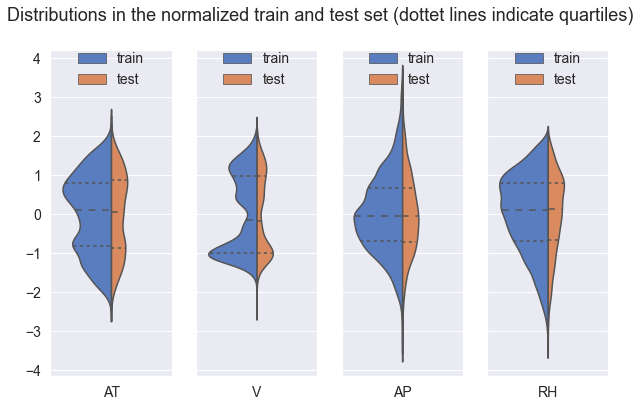

In [21]:
fig, ax = plt.subplots(1,4, figsize=(10,6), sharey=True)
for i, col in enumerate(X_train_tr.columns):
    df = pd.concat([pd.DataFrame({'Values':X_train_tr[col],'Subset':'train'}),
                    pd.DataFrame({'Values':X_test_tr[col],'Subset':'test'})])
    df['Name'] = col
    sns.violinplot(ax=ax[i], data=df, x='Name', y='Values', hue='Subset', split=True, 
                   inner='quartile', scale='count',palette='muted')
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)
    ax[i].legend(loc='center',bbox_to_anchor=(0.5,0.94), frameon=False)
fig.suptitle('Distributions in the normalized train and test set (dottet lines indicate quartiles)', fontsize=18)
plt.show()

<div class="alert alert-block alert-success">
<li>The distributions are zero-centered now
<li>The random division of the data creates a train and test set with similar distributions
</div>

Note: The splitted data set will be used for the analysis of the model and errors in the third section of this notebook. In the next section, a cross-validation style evaluation function will be implemented. 

## Evaluate regression models 
Fast evaluation of different regression models with default hyperparameters. 

First define function to calculate the **root mean squared error** (RMSE):

In [22]:
from sklearn.metrics import mean_squared_error

def get_rmse(model, X, y):
    return np.sqrt(mean_squared_error(y, model.predict(X)))

### Define the model evaluation function
A function to evaluate a single model using the coefficient of determination (R squared score) and the RMSE:
- The input of this function is the raw data (not standardized, not splitted)
- Cross-validation style evaluation using multiple train and test sets
- Return mean scores

In [23]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

def cross_evaluate_model(model, X, y, n_splits=5):
    """
    Will split the data multiple times into train and test set; each time standardizing, 
    fitting and evaluating the regression model.
    Return the mean R squard score and the mean RMSE for both data sets (train and test).
    """
    train_r2 = []
    test_r2  = []
    train_rmse = []
    test_rmse = []
    
    # Create splits
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    kf.get_n_splits(X)
    
    for train_index, test_index in kf.split(X):
        # 1. Get train and test set for current split
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        # 2. Standardize train and test set
        scaler = StandardScaler()
        X_train_tr = scaler.fit_transform(X_train)   
        X_test_tr  = scaler.transform(X_test)   
    
        # 3. Fit model
        regressor = model
        regressor.fit(X_train_tr, y_train)
    
        # 4. Evaluate model
        # R squared score 
        train_r2.append(regressor.score(X_train_tr, y_train))
        test_r2.append(regressor.score(X_test_tr, y_test))
         # RMSE
        train_rmse.append(get_rmse(regressor, X_train_tr, y_train))  
        test_rmse.append(get_rmse(regressor, X_test_tr, y_test)) 

    return {'train_r2': np.mean(train_r2), 'test_r2': np.mean(test_r2), 
            'train_rmse': np.mean(train_rmse), 'test_rmse': np.mean(test_rmse)}

### Create a simple baseline model
The prediction of this model is a constant value, i.e. the mean power output PE (of the train set).

In [24]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MeanRegression(BaseEstimator, RegressorMixin):   
    def fit(self, X, y):
        X, y = check_X_y(X, y)    # Check shape and check for nan values
        self.ymean_ = np.mean(y)  
        return self                # Return the regressor
    
    def predict(self, X):
        check_is_fitted(self) # Check is fit had been called
        X = check_array(X)    # Input validation
        return np.zeros_like(np.array(X)[:,0]) + self.ymean_

In [25]:
# Quick test
mean_reg = MeanRegression().fit(X_train_tr,y_train)
print('mean y_train = %f'%y_train.mean())
print('y_predict = ',mean_reg.predict(X_test_tr.iloc[:3,:]))

mean y_train = 454.295319
y_predict =  [454.29587 454.29587 454.29587]


### Create a list of different regression models to evaluate
All models are initialized with default hyperparameters.

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Define list of different regression models (using default hyperparameters)
models = [MeanRegression(), LinearRegression(), Ridge(), Lasso(),BayesianRidge(), SVR(), 
          DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), 
          XGBRegressor(objective="reg:squarederror"), MLPRegressor()]
names  = ['MeanRegression', 'LinearRegression', 'Ridge', 'Lasso', 'BayesianRidge','SVR', 
          'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor',
          'XGBRegressor','MLPRegressor']

# Set random_state for reproducibility
for model in models:
    if 'random_state' in model.get_params().keys():
        model.set_params(random_state=42)

### Evaluate models

In [27]:
for i, model in enumerate(models):
    print('Evaluating the %s model'%names[i])
    
    result = cross_evaluate_model(model, X, y, n_splits=5) 
    
    if i == 0:
        results = pd.DataFrame(result, index=[0]) # initialize DataFrame to save results
    else:
        results = results.append(result, ignore_index=True)
results.set_index(pd.Series(names), inplace=True)

Evaluating the MeanRegression model
Evaluating the LinearRegression model
Evaluating the Ridge model
Evaluating the Lasso model
Evaluating the BayesianRidge model
Evaluating the SVR model
Evaluating the DecisionTreeRegressor model
Evaluating the RandomForestRegressor model
Evaluating the GradientBoostingRegressor model
Evaluating the XGBRegressor model
Evaluating the MLPRegressor model


### Results

In [28]:
results.sort_values('test_rmse')

,train_r2,test_r2,train_rmse,test_rmse
XGBRegressor,0.987023,0.965230,1.940504,3.175046
RandomForestRegressor,0.994544,0.961662,1.258437,3.335167
GradientBoostingRegressor,0.952992,0.947839,3.694028,3.890512
SVR,0.940751,0.939921,4.147232,4.175317
BayesianRidge,0.928430,0.928336,4.558104,4.560252
LinearRegression,0.928430,0.928336,4.558104,4.560252
Ridge,0.928430,0.928336,4.558106,4.560254
DecisionTreeRegressor,1.000000,0.925908,0.000000,4.636958
MLPRegressor,0.916737,0.915824,4.913105,4.938873
Lasso,0.913037,0.912915,5.024424,5.026278


Plot coefficient of determination (R squared score):

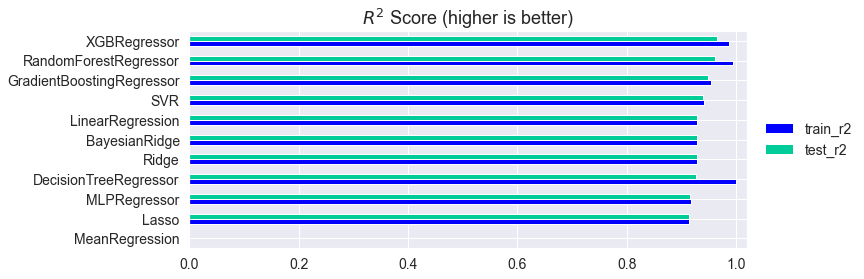

In [29]:
fig, ax = plt.subplots()
results.iloc[:,[0,1]].clip(lower=0).sort_values('test_r2').plot(ax=ax, kind='barh', 
                                                                title='$R^2$ Score (higher is better)', 
                                                                color=plt.cm.winter([0,0.8]), grid=True, 
                                                                figsize=(10,4), xlim=[0,1.02])
ax.legend(loc='center',bbox_to_anchor=(1.11,0.5), frameon=False)
plt.show()

Plot RMSE:

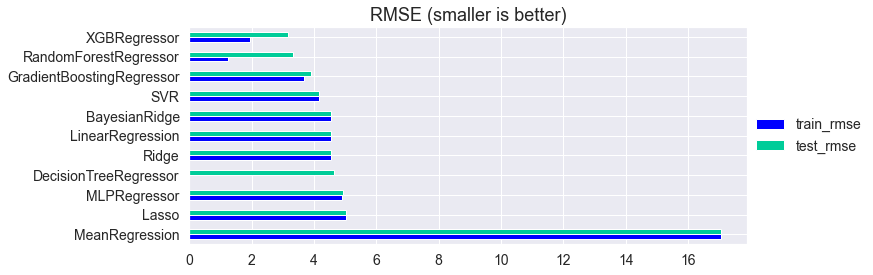

In [30]:
fig, ax = plt.subplots()
results.iloc[:,[2,3]].clip(lower=0).sort_values('test_rmse', ascending=False).plot(ax=ax,kind='barh', 
                                                                                   title='RMSE (smaller is better)', 
                                                                                   color=plt.cm.winter([0,0.8]), 
                                                                                   grid=True, figsize=(10,4))
ax.legend(loc='center',bbox_to_anchor=(1.11,0.5), frameon=False)
plt.show()

<div class="alert alert-block alert-success">
<li>The XGBRegressor and the RandomForestRegressor have the best performance (with default hyperparameters)
<li>Linear regression models (i.e. LinearRegression and regularized models like Ridge, Lasso and BayesianRidge) are simple models but perform quite good
<li>All models perform better than the simple baseline model and therefore extract information out of the data
<li>The DecisionTreeRegressor has an exceptional performance on the train set but doesen't generalize well (i.e. the test score is much lower)
</div>

### Tune hyperparameters for a Random Forest model
A coarse search over the parameters indicated a good model performance for max_features in the range of [2,3] and n_estimators in the range of [300,600]. Now perform a fine randomized search in these ranges.

In [31]:
rfg = RandomForestRegressor(random_state=42)

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distributions = {
        'n_estimators': randint(low=300, high=600),   
        'max_features': randint(low=1,   high=3)   
    }

rnd_search = RandomizedSearchCV(rfg, param_distributions=param_distributions,
                                n_iter=40, cv=5, scoring='neg_mean_squared_error', 
                                random_state=42, verbose=1)
rnd_search.fit(X_train_tr, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=40,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000205F6F774F0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000205F94D3790>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

Show the mean RMSE (smaller is better):

In [33]:
cvres = pd.DataFrame(rnd_search.cv_results_)
cvres.mean_test_score = cvres.mean_test_score.apply(lambda mean_score: np.sqrt(-mean_score)) # calc RMSE
cvres[['mean_test_score', 'params']].sort_values('mean_test_score').head(10)

,mean_test_score,params
19,3.281710,"{'max_features': 2, 'n_estimators': 570}"
12,3.281758,"{'max_features': 2, 'n_estimators': 576}"
10,3.281818,"{'max_features': 2, 'n_estimators': 593}"
28,3.281964,"{'max_features': 2, 'n_estimators': 564}"
39,3.282012,"{'max_features': 2, 'n_estimators': 517}"
37,3.282599,"{'max_features': 2, 'n_estimators': 559}"
11,3.283409,"{'max_features': 2, 'n_estimators': 491}"
38,3.283576,"{'max_features': 2, 'n_estimators': 490}"
18,3.283583,"{'max_features': 2, 'n_estimators': 487}"
7,3.283889,"{'max_features': 2, 'n_estimators': 451}"


In [34]:
rnd_search.best_params_

{'max_features': 2, 'n_estimators': 570}

Use the best hyperparameters from the randomized search and evaluate the model using the model evaluation function from above:

In [35]:
optimized_forest = RandomForestRegressor(**rnd_search.best_params_, random_state=42)
new_result = cross_evaluate_model(optimized_forest, X, y, n_splits=5)
new_result

{'train_r2': 0.9951244104068545,
 'test_r2': 0.9642317496519996,
 'train_rmse': 1.1896573781897233,
 'test_rmse': 3.221295328330816}

Compare the optimized model with the previous model:

In [36]:
new_result['test_rmse'] - results.loc['RandomForestRegressor', 'test_rmse']

-0.11387123914640629

<div class="alert alert-block alert-success">
RMSE slightly reduced by hyperparameter tuning.
</div>

# 3. Analysis of model and residuals
Do the residuals (errors) indicate a problem with the model? What relationship between the features and the target has the model learned?

## Regression diagnostics
Asses how well the model fits the data, e.g. by analysing the residuals.

Create and fit the Random Forest model again using the train set defined in section 1:

In [37]:
optimized_forest = RandomForestRegressor(**rnd_search.best_params_, random_state=42).fit(X_train_tr,y_train)

In [38]:
optimized_forest.score(X_test_tr, y_test)

0.9609840292003714

### Compare true and predicted values
Visualize the prediction results and the true values to get an idea about the prediction quality and the residuals.

Plot predicted vs true values:

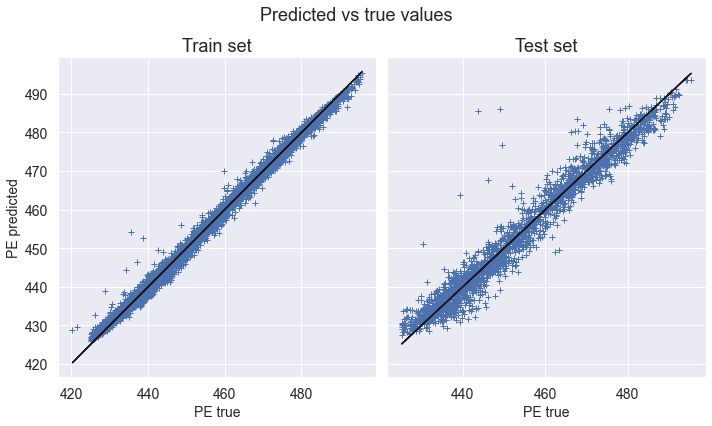

In [39]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,6), sharey=True)

ax0.plot(y_train, optimized_forest.predict(X_train_tr), '+')
ax0.plot(y_train, y_train,'k-')
ax0.set_title('Train set')
ax0.set_xlabel('PE true')
ax0.set_ylabel('PE predicted')

ax1.plot(y_test, optimized_forest.predict(X_test_tr), '+')
ax1.plot(y_test, y_test,'k-')
ax1.set_title('Test set')
ax1.set_xlabel('PE true')

fig.suptitle('Predicted vs true values', fontsize=18)
plt.tight_layout()
plt.show()

Plot true and predicted values (sorted by ascending true values):

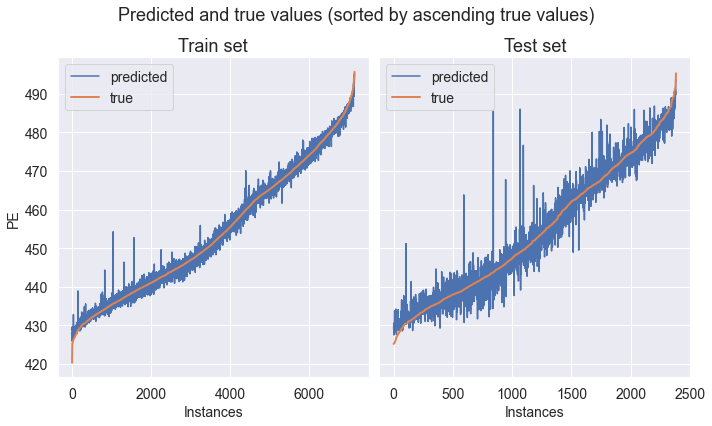

In [40]:
# Train set values
y_train_sorted = y_train.sort_values()
y_train_predict_sorted = pd.Series(optimized_forest.predict(X_train_tr)).loc[y_train_sorted.index]

# Test set values
y_test_sorted = y_test.sort_values()
y_predict_sorted = pd.Series(optimized_forest.predict(X_test_tr)).loc[y_test_sorted.index]

# Plot
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,6), sharey=True)

ax0.plot(y_train_predict_sorted.reset_index(drop=True),label='predicted')
ax0.plot(y_train_sorted.reset_index(drop=True), label='true', lw=2)
ax0.set_title('Train set')
ax0.set_xlabel('Instances')
ax0.set_ylabel('PE')
ax0.legend()

ax1.plot(y_predict_sorted.reset_index(drop=True), label='predicted')
ax1.plot(y_test_sorted.reset_index(drop=True), label='true', lw=2)
ax1.set_title('Test set')
ax1.set_xlabel('Instances')
ax1.legend()

fig.suptitle('Predicted and true values (sorted by ascending true values)', fontsize=18)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<li>The predictions for the train set are generally closer to the true values. This is as expected, since the model has already seen the train data.
<li>A few predictions are way off, but most of them fluctuate around the true values
</div>

### Residual distribution
Calculate the residuals for the test set and analyse the distribution.

In [41]:
y_predict = optimized_forest.predict(X_test_tr)
residuals = y_predict - y_test

Histogram of residuals:

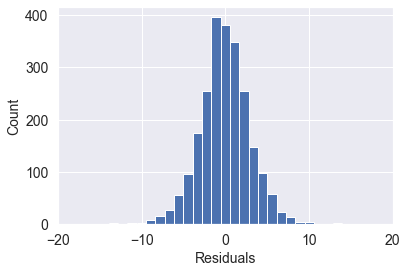

In [42]:
residuals.hist(bins=50)
plt.xlim([-20,20])
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.show()

Kernel Density Estimate (KDE) plot of standardized residuals: 

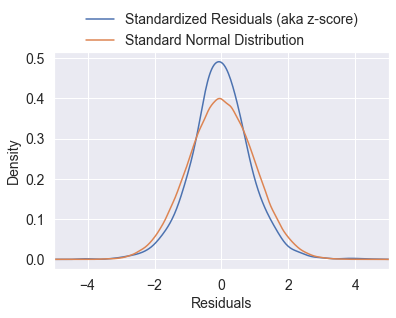

In [43]:
standardized_residuals = (residuals-residuals.mean())/residuals.std()

standardized_residuals.plot.kde(label='Standardized Residuals (aka z-score)')
pd.Series(np.random.normal(size=100000)).plot.kde(label='Standard Normal Distribution')
plt.xlim([-5,5])
plt.legend(loc='center',bbox_to_anchor=(0.5,1.1), frameon=False)
plt.xlabel('Residuals')
plt.show()

<div class="alert alert-block alert-success">
The residuals approximately follow the normal distribution but with a higher density around zero.
</div>

#### Q-Q Plot
- Plot quantiles of the standard normal distribution versus the normalized error
- How much does the error distribution resemble a normal distribution? Examine whether the residuals are normally distributed, i.e. the residuals points follow the straight line.
- Normally distributed errors indicate a complete model, whereas not normally distributed errors indicate that the model may be missing something.

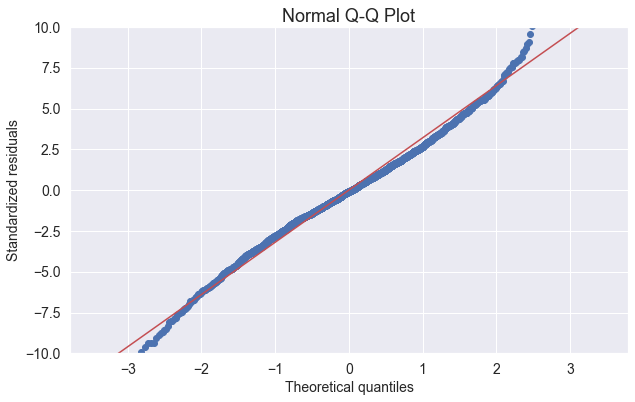

In [44]:
from scipy import stats
fig, ax = plt.subplots(figsize=(10,6))
stats.probplot(residuals, plot=ax)
ax.set_title('Normal Q-Q Plot')
ax.set_ylabel('Standardized residuals')
plt.ylim([-10,10])
plt.show()

<div class="alert alert-block alert-success">
The residuals approximately follow a straight line so we can again assume normality.
</div>

#### Heteroskedasticity
- Heteroskedasticity is the lack of constant residual variance across the range of predicted values 
- This also can indicate an incomplete model
- If the residuals are on a horizontal line, it is a good indication of homoscedasticity (homogeneity of variance of the residuals)
- Heteroscedasticity problems can sometimes be reduced by using a log (or square root) transformation of the target variable

Plot residuals vs predicted target values (and fit a linear regression model to visualize their relationship with an orange line):

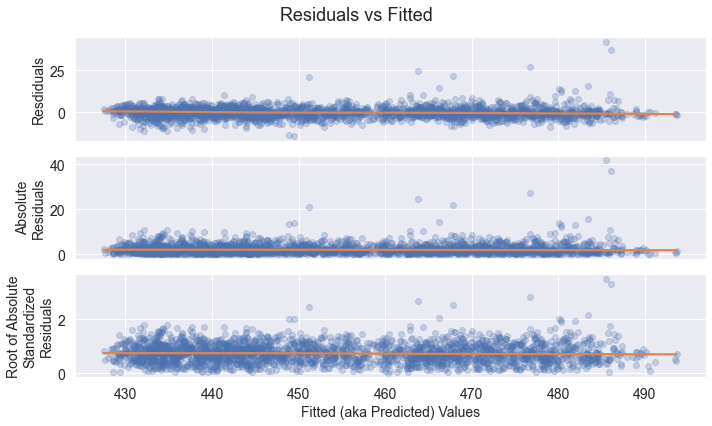

In [45]:
fig, ax = plt.subplots(3,1,sharex=True,figsize=(10,6))
residual_list = [residuals, residuals.abs(), standardized_residuals.abs().apply(lambda x: np.sqrt(x))]
labels    = ['Resdiduals','Absolute\nResiduals','Root of Absolute\nStandardized\nResiduals']
for i, (resid, label) in enumerate(zip(residual_list, labels)):
    sns.regplot(ax=ax[i], x=y_predict, y=resid, scatter_kws={'alpha':0.25}, line_kws={'color':'C1'}, lowess=True)
    ax[i].set_ylabel(label)
fig.suptitle('Residuals vs Fitted',fontsize=18)
plt.xlabel('Fitted (aka Predicted) Values')
fig.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
The model seems to perform equally good on different ranges of the predicted values.
</div>

### Outliers
Analyse extreme residual values.

Boxplot of Residuals:

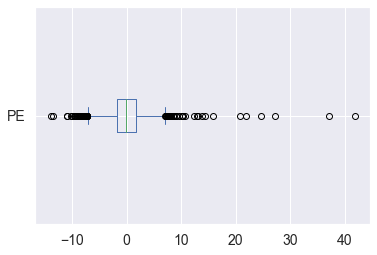

In [46]:
residuals.plot.box(vert=False)
plt.show()

<div class="alert alert-block alert-success">
<li>In the boxplot, the outliers marked by circles are defined as residuals with a distance of more than 1.5*IQR (interqartile range; the box size) from the box edges
<li>There a quite a few outliers. Why are some predictions so bad?
</div>

Create a DataFrame with features, true and predicted target and also the residuals:

In [47]:
X_test_residuals = X_test.copy()
X_test_residuals['PE true'] = y_test
X_test_residuals['PE predicted'] = y_predict
X_test_residuals['residuals'] = residuals
X_test_residuals['standardized_residuals'] = standardized_residuals
X_test_residuals['absolute_standardized_residuals'] = standardized_residuals.abs()
X_test_residuals = X_test_residuals.sort_values('absolute_standardized_residuals', ascending=False)

Inspecting the instances which result in the worst predictions can provide clues about *why* the predictions are so bad.

Inspect the instances which account for the **5 greatest asolute residuals:**

In [48]:
X_test_residuals.head(5)

,AT,V,AP,RH,PE true,PE predicted,residuals,standardized_residuals,absolute_standardized_residuals
1026,6.22,39.849998,1012.049988,86.879997,443.730011,485.525897,41.795886,12.331968,12.331968
2315,7.06,41.740002,1021.950012,90.379997,448.970001,486.060666,37.090665,10.943237,10.943237
700,11.41,41.400002,1019.010010,78.589996,449.500000,476.684979,27.184979,8.019605,8.019605
1781,15.61,38.520000,1018.400024,80.989998,439.209991,463.811913,24.601922,7.257224,7.257224
220,13.78,40.099998,1014.489990,81.860001,445.980011,467.796562,21.816551,6.435131,6.435131


<div class="alert alert-block alert-success">
<li>The instances with the greatest residuals look fine on the first glance (e.g. no unreasonable feature or target values)
<li>It is possible that the errors simply result from the limited capabilities of the regression model
</div>

Now compare some of these outlier instances with **similar instances** (i.e. instances which have similar features values):

In [49]:
def get_similar_rows(df, row_idx, margin=1):
    """Return rows with similar feature values as the row with given index row_idx"""
    df_similar = df.copy()
    for i, val in enumerate(df.iloc[row_idx,:4]):
        df_similar = df_similar.loc[df.iloc[:,i].between(val-margin, val+margin)]
    return df_similar

Example 1: The instance with the greatest absolute error and similar instances:

In [50]:
get_similar_rows(X_test_residuals, row_idx=0, margin=2).round(2)

,AT,V,AP,RH,PE true,PE predicted,residuals,standardized_residuals,absolute_standardized_residuals
1026,6.22,39.849998,1012.049988,86.879997,443.730011,485.53,41.80,12.33,12.33
2277,6.65,38.500000,1014.010010,87.599998,491.540009,486.50,-5.04,-1.49,1.49


Example 2: The instance with the *second* greatest absolute error and similar instances:

In [51]:
get_similar_rows(X_test_residuals, row_idx=1, margin=1.5).round(2)

,AT,V,AP,RH,PE true,PE predicted,residuals,standardized_residuals,absolute_standardized_residuals
2315,7.06,41.740002,1021.950012,90.379997,448.970001,486.06,37.09,10.94,10.94
795,7.53,41.160000,1023.190002,91.279999,475.700012,479.69,3.99,1.17,1.17
1024,8.47,41.259998,1020.570007,91.279999,477.140015,478.02,0.88,0.26,0.26
2285,8.10,40.639999,1020.659973,89.040001,478.269989,478.76,0.49,0.14,0.14
2306,8.14,41.259998,1020.609985,91.279999,477.570007,477.99,0.42,0.12,0.12


<div class="alert alert-block alert-success">
<li>There a five instances with similar feature values and similar predicted target values (PE predicted around 480), but the true target value of the first instance differs significantly from the other instances (PE true around 448 instead of 477).
<li>This could explain why the prediction for the first instance in this table is so bad
<li>The regression model apparently doesen't differentiate between these operating conditions and predicts a value of around ~480 for PE
</div>

Example 3: The instance with the *third* greatest absolute error and similar instances:

In [52]:
get_similar_rows(X_test_residuals, row_idx=2, margin=1.5).round(2)

,AT,V,AP,RH,PE true,PE predicted,residuals,standardized_residuals,absolute_standardized_residuals
700,11.41,41.400002,1019.010010,78.589996,449.500000,476.68,27.18,8.02,8.02
897,10.56,41.540001,1019.919983,78.949997,479.329987,479.25,-0.08,-0.03,0.03


<div class="alert alert-block alert-success">
The observation made in the second example is also true for other examples, i.e. a big prediction error could result from having instances with similar feature values but significantly different target values.
</div>

***
**We assume that a certain operating condition always results in the same power output of the plant.** 

Possible reasons for bad predictions are therefore:

- The model is not complex enough to account for small differences or complex patterns in the feature values. A more complex model is required.
    
- The target is not well defined by the available features: more feature variables are required to describe the target precisely.

- The data contains errors: errors occured during measurement or were introduced subsequently during data processing.
***

## Explainable AI
Better understand and interpret predictions made by a machine learning model.

### Feature importance
How useful are the features at predicting the target?

- Here the impurity-based Random Forest feature importance is displayed 
- Alternatives methods to examine feature importance are e.g. permutation importance or SHAP values

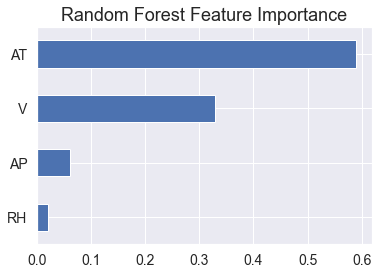

In [53]:
ser = pd.Series({col: optimized_forest.feature_importances_[i] for i, col in enumerate(X_train_tr.columns)})
ser.sort_values().plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.show()

<div class="alert alert-block alert-success">
AT and V are the most important features because of their strong correlation with PE (see section 1).
</div>

### Permutation feature importance
"The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled". "The drop in the model score is indicative of how much the model depends on the feature".

In [54]:
from sklearn.inspection import permutation_importance
result = permutation_importance(optimized_forest, X_test_tr, y_test, n_repeats=10, random_state=42, n_jobs=2)
pd.Series(result)

importances_mean    [0.9970771692375642, 0.17026760911708574, 0.02...
importances_std     [0.022231488228967092, 0.002924986755580046, 0...
importances         [[0.9944515576456078, 0.9845250295488474, 1.00...
dtype: object

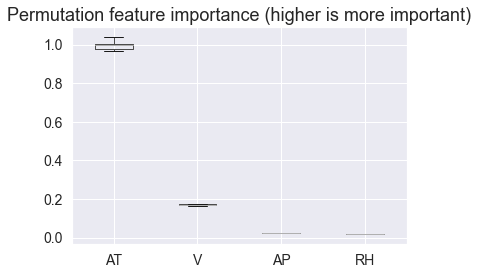

In [55]:
pd.DataFrame(data=result.importances, index=X_test_tr.columns).T.boxplot()
plt.title('Permutation feature importance (higher is more important)')
plt.show()

<div class="alert alert-block alert-success"> 
The permutation importances confirm the previous results.
</div>

### SHAP values
"Shap values show how much a given feature changed the prediction (compared to if that prediction was made at some baseline value of that feature)."

In [56]:
import shap
explainer = shap.TreeExplainer(optimized_forest)
# use the first 500 instances from the test set to calc shap values
shap_values = explainer.shap_values(X_train_tr.head(500)) 

Plot SHAP values for the first 500 instances of the train set:

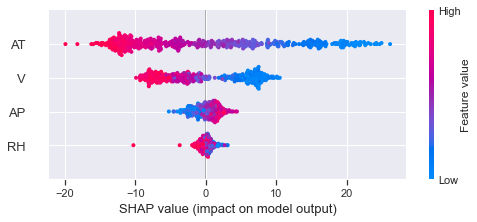

In [57]:
shap.summary_plot(shap_values, X_train_tr.head(500))

#### SHAP feature importance
*Mean absolute shap values* can be used to measure the (global) feature importance:

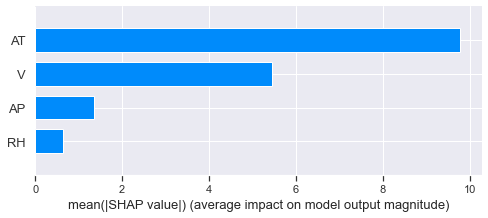

In [58]:
shap.summary_plot(shap_values, feature_names=X_train_tr.columns, plot_type="bar")

<div class="alert alert-block alert-success">
The shap value feature importances confirm the previous results.
</div>

#### Explain local feature impact
Shap values also enable the explanation of the local feature impact for a specific instance.

**Force plot:**
- The force plot visualizes shap values for the features of a single instance
- The shap values are represented by the size of the bar and show the magnitude of the feature's effect
- Pink features cause to increase the prediction and blue features cause to decrease the prediction relative to the baseline (i.e. the average of the predicted values)
- The sum of all feature shap values equals the difference between the predicted value and the baseline value

In [59]:
idx = 4       # index of train set instance to be explained
shap.initjs() # required for visualization
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:])


<div class="alert alert-block alert-success">
Feature impact for this specific instance:
<li>The AT value of ~28 and the V value of ~75 have a strong negative impact on PE (i.e. they decrease PE)
<li>RH and AP have a small positive impact on PE
</div>

### Partial dependence plot (PDP)
What does ist show?
- The PDP shows the *average* effect one or two features have on the predicted outcome of a machine learning model (averaged over multiple instances)
- The interpretations are *marginal*, considering a feature at a time
- "PDP is a global method, it takes into account all instances and makes a statement about the global relationship of a feature with the predicted outcome"

Why use it?
- You can interpret the result of any "black box" learning methods
- Learn about the relationship between the predicted outcome and a single feature, e.g. linear or more complex

Plot the PDP and also the train data:

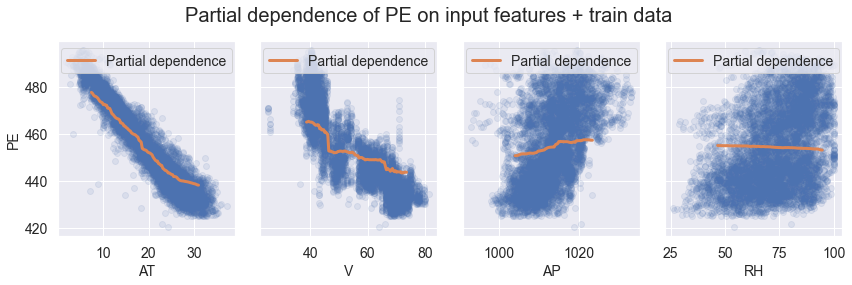

In [60]:
from sklearn.inspection import partial_dependence

average = pd.DataFrame() # y values (target)
values = pd.DataFrame()  # x values (features)

# Get the data for the PDP plot 
for i, feature_name in enumerate(features):
    pdp = partial_dependence(optimized_forest,       
                             features=[feature_name],
                             X=X_train_tr,    
                             grid_resolution=100,
                             kind='average') 
    
    average[feature_name] = pdp['average'][0]
    values[feature_name]  = pdp['values'][0]

# The feature values are standardized, because the model expects them to be
# Get the non-standardized feature values by using the inverse transformation
values_inverse = std.inverse_transform(values)
values_inverse = pd.DataFrame(values_inverse, columns=features)

# Plot
fig, ax = plt.subplots(1,4, figsize=(12,4), sharey=True)
for i, axi in enumerate(ax):
    axi.scatter(X_train.iloc[:,i], y_train, alpha=0.1)
    axi.plot(values_inverse.iloc[:,i], average.iloc[:,i],c='C1',label='Partial dependence', lw=3)
    axi.set_xlabel(features[i])
    if i==0: axi.set_ylabel('PE')
    axi.legend(loc='upper center')
plt.subplots_adjust(wspace=0.1)
fig.suptitle('Partial dependence of PE on input features + train data', fontsize=20)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<li>The model learned, that the relationship between most of the features and the predicted outcome is approximately linear (on average)
<li>The relationship between V and the predicted outcome is a bit more complex, with a drop of the predicted PE about 7 MW around V=47.
<li>Overall, the relationships look reasonable and don't indicate a problem with the model.
</div>